# **Exploratory data analysis for checkbox classification**

## **Importing libraries**

In [79]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import ToTensor
from pathlib import Path
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import os

## **Exploring data**
Based on the analysis in this section, there are 515 images in the given dataset including 222 checked, 155 unchecked, and 138 other images.
Different images have different sizes, especially in the other group, the image sizes are larger than checkbox images.

In [2]:
img_path = {
    'checked': list(Path('./data/checked').glob('*.png')),
    'other': list(Path('./data/other').glob('*.png')),
    'unchecked': list(Path('./data/unchecked').glob('*.png')),
}

print("size per classes", {k: len(v) for k, v in img_path.items()})

size per classes {'checked': 222, 'other': 138, 'unchecked': 155}


In [3]:
def get_resolution(path: Path):
    return mpimg.imread(path).shape

classes_to_resolutions = {
    cls: [get_resolution(pth) for pth in img_paths] for cls, img_paths in img_path.items()
}

for cls, resolutions in classes_to_resolutions.items():
    print(f"Resolutions for class '{cls}': {resolutions}")

Resolutions for class 'checked': [(44, 464, 4), (72, 362, 4), (80, 286, 4), (78, 196, 4), (60, 94, 4), (68, 228, 4), (82, 160, 4), (122, 554, 4), (26, 24, 4), (52, 54, 4), (58, 142, 4), (60, 176, 4), (80, 188, 4), (74, 176, 4), (56, 488, 4), (62, 532, 4), (84, 580, 4), (86, 178, 4), (54, 60, 4), (74, 318, 4), (74, 306, 4), (74, 68, 4), (74, 136, 4), (502, 446, 4), (70, 82, 4), (102, 116, 4), (58, 194, 4), (62, 76, 4), (80, 240, 4), (78, 168, 4), (64, 218, 4), (66, 142, 4), (130, 102, 4), (82, 240, 4), (84, 274, 4), (72, 198, 4), (38, 422, 4), (62, 320, 4), (68, 54, 4), (58, 378, 4), (64, 234, 4), (84, 170, 4), (34, 38, 4), (84, 1088, 4), (42, 196, 4), (86, 198, 4), (52, 46, 4), (62, 118, 4), (90, 132, 4), (72, 258, 4), (50, 168, 4), (90, 478, 4), (54, 66, 4), (136, 144, 4), (48, 138, 4), (72, 408, 4), (50, 162, 4), (82, 90, 4), (70, 172, 4), (66, 60, 4), (90, 154, 4), (58, 280, 4), (52, 96, 4), (56, 224, 4), (98, 124, 4), (64, 184, 4), (48, 76, 4), (48, 46, 4), (52, 206, 4), (54, 130, 

### **Image size distribution**

In [4]:
for class_name, resolutions in classes_to_resolutions.items():
    xs = [res[0] for res in resolutions]
    ys = [res[1] for res in resolutions]
    print(f'{class_name} min_height: {min(xs)} min_width: {min(ys)} max_height:{max(xs)} max_width:{max(ys)}')
    plt.plot(xs, ys, 'o', label=class_name)

plt.legend(numpoints=1)
plt.show()

checked min_height: 26 min_width: 24 max_height:502 max_width:1088
other min_height: 46 min_width: 32 max_height:494 max_width:1804
unchecked min_height: 40 min_width: 48 max_height:220 max_width:798


### **Samples of images from each class**

In [81]:
def show_img_sample(img_path, name):
    fig = plt.gcf()
    fig.set_size_inches(16, 16)
    for i, img in enumerate(img_path[:16]):
        sp = plt.subplot(4, 4, i+1)
        sp.axis('Off')
        sp.set_title(name)
        img_obj = mpimg.imread(img)
        plt.imshow(img_obj)
    plt.show()

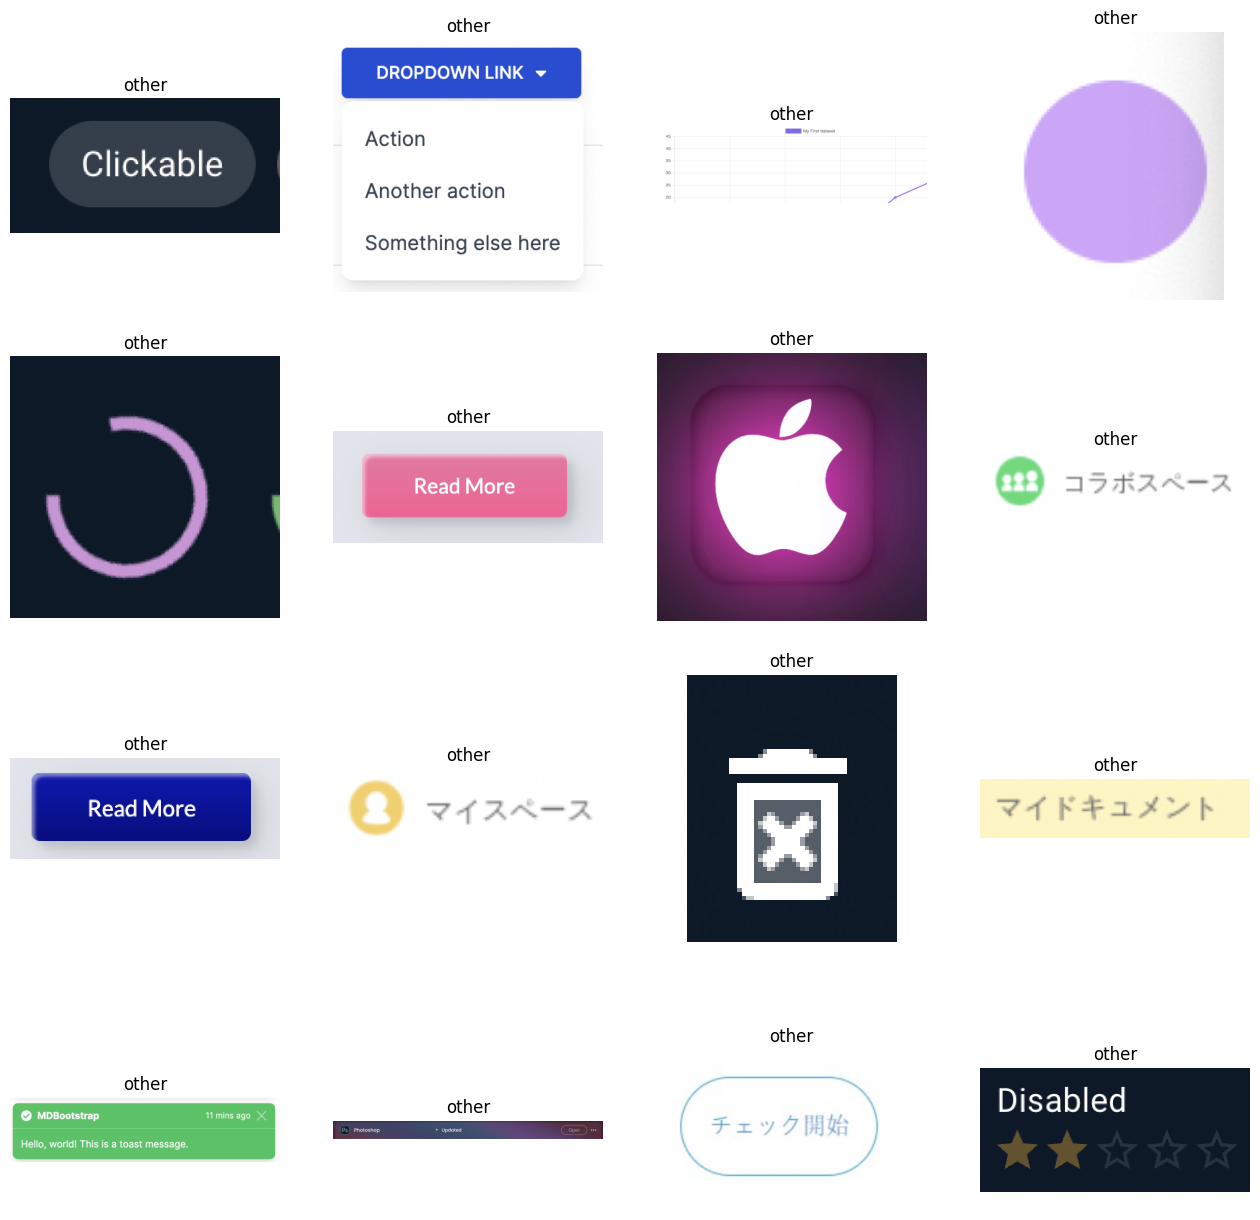

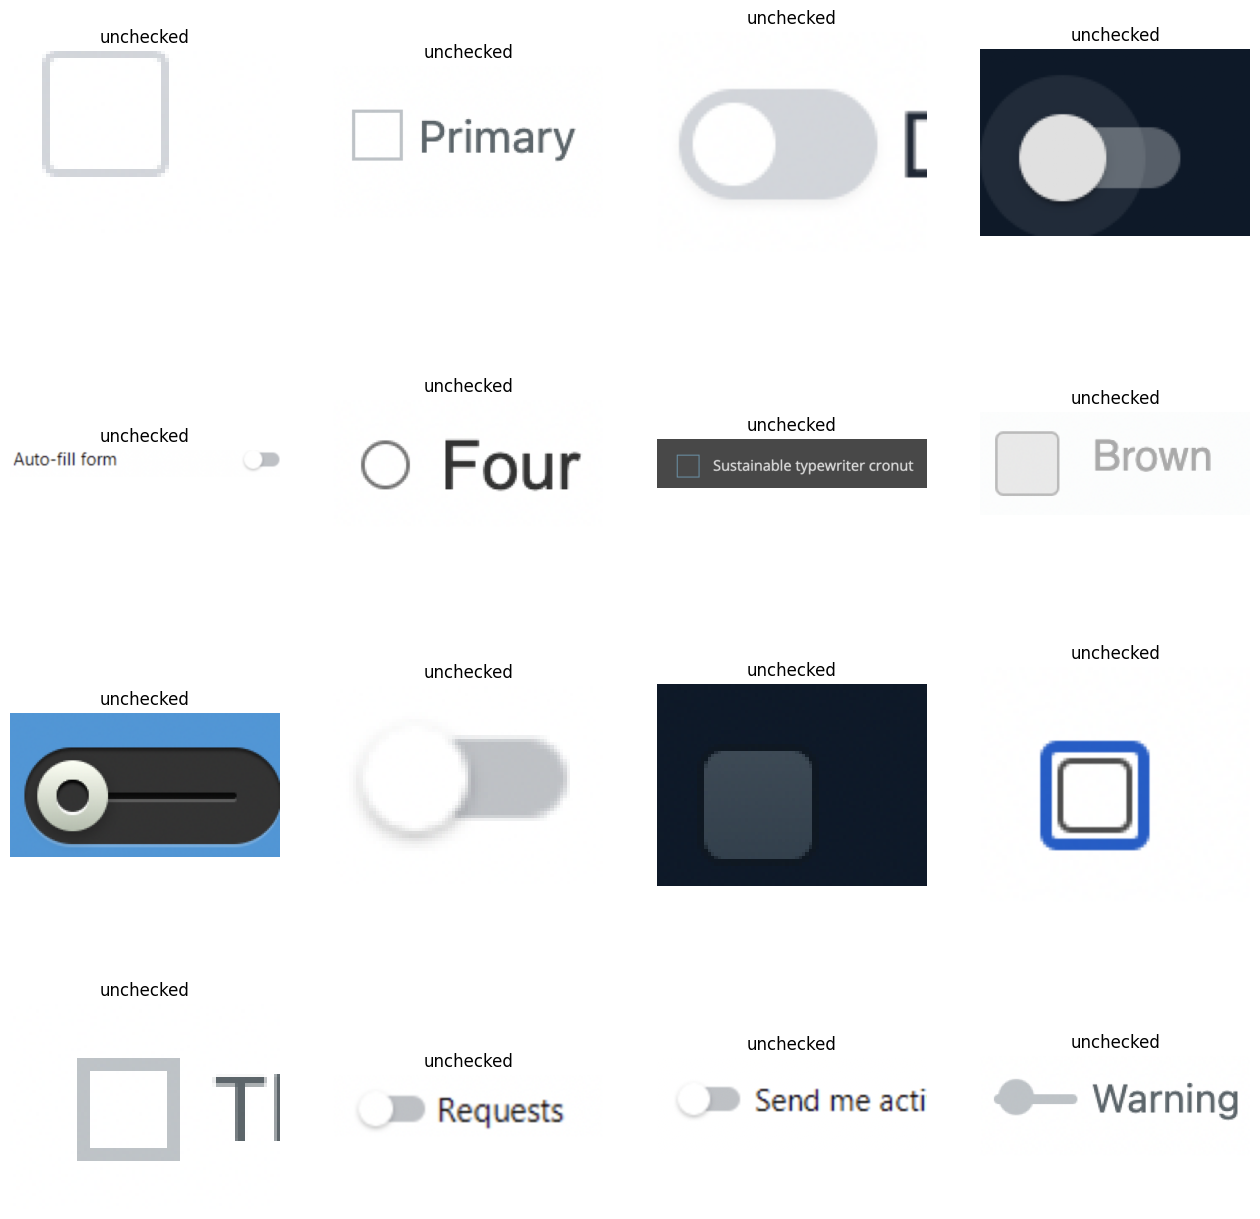

In [82]:
show_img_sample(img_path['checked'], 'checked')
show_img_sample(img_path['other'], 'other')
show_img_sample(img_path['unchecked'], 'unchecked')

## **Playing with the models**
This secion is the main part of the CNN modeling experiment, which includes both the model implementation and performance analysis.
Here is the details of each part:

1. Data preparation and augmentation
    - For each image, I first convert the image color from four channels (i.e., RGBA) into three channels.
    - Then, I resize it into 100*100 pixels.
    - After that, I convert the image to Pytorch tensor.
    - Finally, I normalize the value in the tensor image by using mean=0.5 and std=0.5 as shown in the following equation.
        - output[channel] = (input[channel] - mean[channel]) / std[channel].
2. Model design
    - As the given dataset size is relatively small (i.e., 515 image) with the limitation of the computational resource (i.e., laptop), I decided to use six types of CNN models with small number of parameters in the network based on [this page](https://pytorch.org/vision/main/models.html) to avoid the overfitting issue and save the computational cost.
    - Here is the list of models:
        1. Modified [LeNet](https://en.wikipedia.org/wiki/LeNet)
            - I modify the input layer to be able to receive a tensor image in size 3 * 100 * 100.
        2. [ResNet18](https://pytorch.org/vision/main/models/resnet.html)
        3. [MobileNetV3](https://pytorch.org/vision/main/models/mobilenetv3.html)
        4. [EfficientNetV2S](https://pytorch.org/vision/main/models/efficientnetv2.html)
        5. [ShuffleNetV2](https://pytorch.org/vision/main/models/shufflenetv2.html)
        6. [SqueezeNet](https://pytorch.org/vision/main/models/squeezenet.html)
3. Training setting
    - For all models, I use the following setting:
        1. Optimizer: [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) with learning rate 0.001
        2. Epoch: 30
        3. Hyperparameters: default
    - For the training process, I set the model trainer to use [deteministic](https://lightning.ai/docs/pytorch/2.2.1/common/trainer.html#init) algorithm to ensure the reproducibility of the result.
4. Evaluation setting
    - Data splitting: Training 70%, validating 20%, and testing 10%
        - Use stratified random sampling to ensure that the distributions of classes in training, validating, and testing are similar.
        - All random functions have random seed to ensure the reproducibility of the evaluation result.
    - Evaluation metrics:
        - For all training, validating, and testing processes have the following metrics: 
            1. Loss: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
            2. Accuracy
            3. Precision
            4. Recall
            5. F1 score
        - I also measure the total training time for 30 Epoch.
        - Note that all metrics are visualized with Tensorboard library.

### **Dataset loader implementation**

In [182]:
class CheckBoxDataset(Dataset):
    def __init__(self, root_dir, target_size=(2000, 2000), padding=True, transform=None):
        self.root_dir = root_dir
        self.target_size = target_size
        self.padding = padding
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.img_paths = []
        self.transform = transform
        for cls in self.classes:
            class_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.img_paths.append((img_path, self.class_to_idx[cls]))
        self.img_paths.sort(key=lambda w: (w[1], w[0]))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx]
        img = plt.imread(img_path)
        if img.shape[-1] == 4:
            img = img[..., :3]

        img = self.transform(img)

        return img, label

class CheckBoxDataModule(L.LightningDataModule):
    def __init__(self, root_dir, target_size=(2000, 2000), padding=True, transform=None, random_seed=64, split_size=[0.7, 0.2, 0.1]):
        self.root_dir = root_dir
        self.target_size = target_size
        self.padding = padding
        self.random_seed = random_seed
        self.split_size = split_size
        self.transform = transform if transform else transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.target_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def setup(self, stage):
        dataset = CheckBoxDataset(self.root_dir, target_size=self.target_size, padding=self.padding, transform=self.transform)
        dataset_size = len(dataset)
        train_size = int(self.split_size[0] * dataset_size)
        validate_size = int(self.split_size[1] * dataset_size)

        indices = list(range(dataset_size))
        labels = [label for _, label in dataset]
        train_indices, validate_test_indices = train_test_split(indices, train_size=train_size, stratify=labels, random_state=self.random_seed)
        validate_indices, test_indices = train_test_split(validate_test_indices, train_size=validate_size, stratify=[labels[i] for i in validate_test_indices])

        self.train_dataset = Subset(dataset, train_indices)
        self.validate_dataset = Subset(dataset, validate_indices)
        self.test_dataset = Subset(dataset, test_indices)

    def train_dataloader(self):
        return DataLoader(self.train_dataset)

    def val_dataloader(self):
        return DataLoader(self.validate_dataset)

    def test_dataloader(self):
        return DataLoader(self.test_dataset)

### **CNN model implementation**

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#### Modified LeNet

In [199]:
class LeNet(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc0 = nn.Linear(16 * 22 * 22, 120)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16 * 22 * 22)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'test')

    def performance_logger(self, batch, phase_name):
        x, y = batch
        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)
        self.log(f'{phase_name}_loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        self.log(f'{phase_name}_acc', acc, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log(f'{phase_name}_precision', precision, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_recall', recall, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_f1', f1, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        return loss

#### ResNet18

In [170]:
from torchvision.models import resnet18

class ResNet18(L.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model_net = resnet18(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model_net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'test')

    def performance_logger(self, batch, phase_name):
        x, y = batch
        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)
        self.log(f'{phase_name}_loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        self.log(f'{phase_name}_acc', acc, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log(f'{phase_name}_precision', precision, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_recall', recall, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_f1', f1, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        return loss

#### MobileNetV3 Large

In [171]:
from torchvision.models import mobilenet_v3_large

class MobileNetV3(L.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model_net = mobilenet_v3_large(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model_net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'test')

    def performance_logger(self, batch, phase_name):
        x, y = batch
        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)
        self.log(f'{phase_name}_loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        self.log(f'{phase_name}_acc', acc, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log(f'{phase_name}_precision', precision, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_recall', recall, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_f1', f1, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        return loss

#### EfficientNetV2S

In [173]:
from torchvision.models import efficientnet_v2_s

class EfficientNetV2S(L.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model_net = efficientnet_v2_s(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model_net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'test')

    def performance_logger(self, batch, phase_name):
        x, y = batch
        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)
        self.log(f'{phase_name}_loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        self.log(f'{phase_name}_acc', acc, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log(f'{phase_name}_precision', precision, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_recall', recall, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_f1', f1, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        return loss

#### ShuffleNetV2 x2.0

In [183]:
from torchvision.models import shufflenet_v2_x2_0

class ShuffleNetV2(L.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model_net = shufflenet_v2_x2_0(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model_net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'test')

    def performance_logger(self, batch, phase_name):
        x, y = batch
        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)
        self.log(f'{phase_name}_loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        self.log(f'{phase_name}_acc', acc, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log(f'{phase_name}_precision', precision, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_recall', recall, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_f1', f1, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        return loss

#### SqueezeNet1_1

In [176]:
from torchvision.models import squeezenet1_1

class SqueezeNet1_1(L.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model_net = squeezenet1_1(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.model_net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'val')

    def test_step(self, batch, batch_idx):
        return self.performance_logger(batch, 'test')

    def performance_logger(self, batch, phase_name):
        x, y = batch
        y_hat = self(x)

        loss = F.cross_entropy(y_hat, y)
        self.log(f'{phase_name}_loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        self.log(f'{phase_name}_acc', acc, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        precision = precision_score(y.cpu(), preds.cpu(), average='macro')
        recall = recall_score(y.cpu(), preds.cpu(), average='macro')
        f1 = f1_score(y.cpu(), preds.cpu(), average='macro')
        self.log(f'{phase_name}_precision', precision, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_recall', recall, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'{phase_name}_f1', f1, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        return loss

### **Model experiment**

#### Setup dataset loader

In [71]:
import warnings
warnings.filterwarnings('ignore')

In [128]:
L.seed_everything(64, workers=True)
dataset = CheckBoxDataModule('./data', padding=False, target_size=(100, 100))
dataset.prepare_data()
dataset.setup('')
dataset.train_dataloader()

515 360 51
360 51


#### Training, Validating, and Testing

In [200]:
le_net = LeNet()
le_trainer = L.Trainer(max_epochs=30, logger=TensorBoardLogger('lightning_logs', name='lenet'), deterministic=True, enable_progress_bar=False)
le_trainer.fit(le_net, train_dataloaders=dataset.train_dataloader(), val_dataloaders=dataset.val_dataloader())
le_trainer.test(dataloaders=dataset.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 456   
1 | conv2 | Conv2d | 2.4 K 
2 | fc0   | Linear | 929 K 
3 | fc1   | Linear | 10.2 K
4 | fc2   | Linear | 255   
---------------------------------
942 K     Trainable params
0         Non-trainable params
942 K     Total params
3.771     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.
Restoring states from the checkpoint path at lightning_logs/lenet/version_0/checkpoints/epoch=29-step=10800.ckpt
Loaded model weights from the checkpoint at lightning_logs/lenet/version_0/checkpoints/epoch=29-step=10800.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.5480769276618958
      test_f1_epoch         0.5480769276618958
     test_loss_epoch         5.647021293640137
  test_precision_epoch      0.5480769276618958
    test_recall_epoch       0.5480769276618958
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 5.647021293640137,
  'test_acc_epoch': 0.5480769276618958,
  'test_precision_epoch': 0.5480769276618958,
  'test_recall_epoch': 0.5480769276618958,
  'test_f1_epoch': 0.5480769276618958}]

In [188]:
res_net = ResNet18(num_classes=3)
res_trainer = L.Trainer(max_epochs=30, logger=TensorBoardLogger('lightning_logs', name='resnet'), deterministic=True, enable_progress_bar=False)
res_trainer.fit(res_net, train_dataloaders=dataset.train_dataloader(), val_dataloaders=dataset.val_dataloader())
res_trainer.test(dataloaders=dataset.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/resnet

  | Name      | Type   | Params
-------------------------------------
0 | model_net | ResNet | 11.2 M
-------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.
Restoring states from the checkpoint path at lightning_logs/resnet/version_0/checkpoints/epoch=29-step=10800.ckpt
Loaded model weights from the checkpoint at lightning_logs/resnet/version_0/checkpoints/epoch=29-step=10800.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.4038461446762085
      test_f1_epoch         0.4038461446762085
     test_loss_epoch        1.7355201244354248
  test_precision_epoch      0.4038461446762085
    test_recall_epoch       0.4038461446762085
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 1.7355201244354248,
  'test_acc_epoch': 0.4038461446762085,
  'test_precision_epoch': 0.4038461446762085,
  'test_recall_epoch': 0.4038461446762085,
  'test_f1_epoch': 0.4038461446762085}]

In [189]:
mob_net = MobileNetV3(num_classes=3)
mob_trainer = L.Trainer(max_epochs=30, logger=TensorBoardLogger('lightning_logs', name='mobilenet'), deterministic=True, enable_progress_bar=False)
mob_trainer.fit(mob_net, train_dataloaders=dataset.train_dataloader(), val_dataloaders=dataset.val_dataloader())
mob_trainer.test(dataloaders=dataset.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/mobilenet

  | Name      | Type        | Params
------------------------------------------
0 | model_net | MobileNetV3 | 4.2 M 
------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.823    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.
Restoring states from the checkpoint path at lightning_logs/mobilenet/version_0/checkpoints/epoch=29-step=10800.ckpt
Loaded model weights from the checkpoint at lightning_logs/mobilenet/version_0/checkpoints/epoch=29-step=10800.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.4326923191547394
      test_f1_epoch         0.4326923191547394
     test_loss_epoch        229.66542053222656
  test_precision_epoch      0.4326923191547394
    test_recall_epoch       0.4326923191547394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 229.66542053222656,
  'test_acc_epoch': 0.4326923191547394,
  'test_precision_epoch': 0.4326923191547394,
  'test_recall_epoch': 0.4326923191547394,
  'test_f1_epoch': 0.4326923191547394}]

In [190]:
eff_net = EfficientNetV2S(num_classes=3)
eff_trainer = L.Trainer(max_epochs=30, logger=TensorBoardLogger('lightning_logs', name='efficientnet'), deterministic=True, enable_progress_bar=False)
eff_trainer.fit(eff_net, train_dataloaders=dataset.train_dataloader(), val_dataloaders=dataset.val_dataloader())
eff_trainer.test(dataloaders=dataset.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/efficientnet

  | Name      | Type         | Params
-------------------------------------------
0 | model_net | ShuffleNetV2 | 5.4 M 
-------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.405    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.
Restoring states from the checkpoint path at lightning_logs/efficientnet/version_0/checkpoints/epoch=29-step=10800.ckpt
Loaded model weights from the checkpoint at lightning_logs/efficientnet/version_0/checkpoints/epoch=29-step=10800.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.21153846383094788
      test_f1_epoch         0.21153846383094788
     test_loss_epoch        3.6163930892944336
  test_precision_epoch      0.21153846383094788
    test_recall_epoch       0.21153846383094788
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 3.6163930892944336,
  'test_acc_epoch': 0.21153846383094788,
  'test_precision_epoch': 0.21153846383094788,
  'test_recall_epoch': 0.21153846383094788,
  'test_f1_epoch': 0.21153846383094788}]

In [191]:
shu_net = ShuffleNetV2(num_classes=3)
shu_trainer = L.Trainer(max_epochs=30, logger=TensorBoardLogger('lightning_logs', name='shufflenet'), deterministic=True, enable_progress_bar=False)
shu_trainer.fit(shu_net, train_dataloaders=dataset.train_dataloader(), val_dataloaders=dataset.val_dataloader())
shu_trainer.test(dataloaders=dataset.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/shufflenet

  | Name      | Type         | Params
-------------------------------------------
0 | model_net | ShuffleNetV2 | 5.4 M 
-------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.405    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.
Restoring states from the checkpoint path at lightning_logs/shufflenet/version_0/checkpoints/epoch=29-step=10800.ckpt
Loaded model weights from the checkpoint at lightning_logs/shufflenet/version_0/checkpoints/epoch=29-step=10800.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.4326923191547394
      test_f1_epoch         0.4326923191547394
     test_loss_epoch         1.098345398902893
  test_precision_epoch      0.4326923191547394
    test_recall_epoch       0.4326923191547394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 1.098345398902893,
  'test_acc_epoch': 0.4326923191547394,
  'test_precision_epoch': 0.4326923191547394,
  'test_recall_epoch': 0.4326923191547394,
  'test_f1_epoch': 0.4326923191547394}]

In [192]:
squ_net = SqueezeNet1_1(num_classes=3)
squ_trainer = L.Trainer(max_epochs=30, logger=TensorBoardLogger('lightning_logs', name='squeezenet'), deterministic=True, enable_progress_bar=False)
squ_trainer.fit(squ_net, train_dataloaders=dataset.train_dataloader(), val_dataloaders=dataset.val_dataloader())
squ_trainer.test(dataloaders=dataset.test_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/squeezenet

  | Name      | Type       | Params
-----------------------------------------
0 | model_net | SqueezeNet | 724 K 
-----------------------------------------
724 K     Trainable params
0         Non-trainable params
724 K     Total params
2.896     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.
Restoring states from the checkpoint path at lightning_logs/squeezenet/version_0/checkpoints/epoch=29-step=10800.ckpt
Loaded model weights from the checkpoint at lightning_logs/squeezenet/version_0/checkpoints/epoch=29-step=10800.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.25961539149284363
      test_f1_epoch         0.25961539149284363
     test_loss_epoch         1.09861159324646
  test_precision_epoch      0.25961539149284363
    test_recall_epoch       0.25961539149284363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 1.09861159324646,
  'test_acc_epoch': 0.25961539149284363,
  'test_precision_epoch': 0.25961539149284363,
  'test_recall_epoch': 0.25961539149284363,
  'test_f1_epoch': 0.25961539149284363}]

#### Performance visualization
To visualize the full list of evaluation matrics, please run two following cells.

In [197]:
%load_ext tensorboard

In [198]:
%tensorboard --logdir lightning_logs/

#### Results
Based on the training time, training lost, training accuracy, validating acuracy, and testing accuracy, LeNet outperforms other models.
<img src="./image/training_time.png" width="800">
<img src="./image/training_lost.png" width="800">
<img src="./image/training_acc.png" width="800">
<img src="./image/validating_acc.png" width="800">
<img src="./image/testing_acc.png" width="800">

#### Saving the best model for production inference

In [201]:
le_trainer.save_checkpoint('./model/lenet_model.ckpt')

### **Areas of improvement**
1. Data preparation and augmentation
    - Currently, I fixed the image augmentation to just only one setting which may largly affect the result of prediction.
    - Applying more image augmentation can add more meaningful patterns to the input tensor.
2. Model customization
    - This iteration of experiment uses the existing models with only fews customization. 
    - As the current dataset is small, using too complex models can lead to the overfit issue.
    - Customizing our own model can increase the prediction accuracy of the unknown input image. 
3. Hyperparameter tuning
    - All model implementations uses only default hyperparameters.
    - Tuning those hyperarameters can help us to improve the overall model performance.